In [1]:
import numpy as np
from scipy.io import loadmat
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# ---------- Load Data ----------
def load_featset(file_path):
    mat_data = loadmat(file_path)
    featset = mat_data['FeatSet']
    samples = []
    for i in range(featset.shape[0]):  # people
        row = []
        for j in range(featset.shape[1]):  # gestures
            arr = featset[i, j]
            row.append(arr)
        samples.append(row)
    return np.array(samples)  # shape: (N_people, 16, 233, 48)

In [4]:
# Load each session
data_session1 = load_featset('Forearm_Session1.mat')
data_session2 = load_featset('Forearm_Session2.mat')
data_session3 = load_featset('Forearm_Session3.mat')  # test

print(data_session1.shape)

(41, 16, 233, 48)


In [ ]:
# Use sessions 1 & 2 for training
train_data = np.concatenate((data_session1, data_session2), axis=0)


# test_data = data_session3

# Use all sessions for testing
test_data = np.concatenate((data_session1, data_session2, data_session3), axis=0)

In [6]:
# ---------- Dataset ----------
def prepare_data(data_tensor):
    """Flatten [subjects, gestures, 233, 48] → list of (48, 233), label=gesture"""
    subjects, gestures, time_steps, features = data_tensor.shape
    data = []
    for subj in range(subjects):
        for gesture in range(gestures):
            signal = data_tensor[subj, gesture]  # [233, 48]
            signal = signal.T  # → [48, 233]
            label = gesture
            data.append((signal, label))
    return data


In [7]:
# Prepare datasets
train_dataset = prepare_data(train_data)
test_dataset = prepare_data(test_data)



In [12]:
print(len(train_dataset), len(test_dataset))

410 205


In [63]:
from torch.utils.data import Dataset, DataLoader

class EMGGestureDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

train_loader = DataLoader(EMGGestureDataset(train_dataset), batch_size=32, shuffle=True)
test_loader = DataLoader(EMGGestureDataset(test_dataset), batch_size=32)




In [64]:
class DilatedCNN1D_Temporal(nn.Module):
    def __init__(self, in_channels=48, num_classes=16, dropout_rate=0.3):
        super(DilatedCNN1D_Temporal, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, dilation=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout1d(dropout_rate)  # Add dropout after first conv
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, dilation=2, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout1d(dropout_rate)  # Add dropout after second conv
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, dilation=4, padding=4)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout1d(dropout_rate)  # Add dropout after third conv
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc_dropout = nn.Dropout(dropout_rate)  # Add dropout before final FC layer
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # x: [batch_size, channels=48, time_steps=233]
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        
        x = self.pool(x).squeeze(-1)  # shape: [batch, 256]
        x = self.fc_dropout(x)
        return self.fc(x)


In [ ]:
epochs = 3000
patience = 30
lr = 5e-4

In [66]:
all_true_labels = []
all_pred_labels = []


def evaluate(model, data_loader, criterion, device):
    global all_true_labels, all_pred_labels
    all_true_labels = []
    all_pred_labels = []

    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            total_loss += loss.item()

            _, preds = torch.max(out, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            all_true_labels.extend(y_batch.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())

    return total_loss / len(data_loader), 100 * correct / total

In [ ]:

def train_model(model, train_loader, test_loader, epochs, patience, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(out, 1)
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        print(f"Epoch {epoch+1}: "
              f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.2f}% | "
              f"Test Loss = {val_loss:.4f}, Test Acc = {val_acc:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break



In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def print_confusion_matrix():
    global all_true_labels, all_pred_labels
    cm = confusion_matrix(all_true_labels, all_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [69]:
import torch

model = DilatedCNN1D_Temporal(in_channels=48, num_classes=16)
train_model(model, train_loader, test_loader, epochs, patience, lr)

# Save the model to a file
torch.save(model, 'last_saved_model.pth')
print("Model saved as 'last_saved_model.pth'")

Epoch 1: Train Loss = 2.4756, Train Acc = 21.80% | Test Loss = 2.1252, Test Acc = 40.55%
Epoch 2: Train Loss = 1.9678, Train Acc = 38.49% | Test Loss = 1.6404, Test Acc = 47.87%
Epoch 3: Train Loss = 1.7362, Train Acc = 44.36% | Test Loss = 1.6643, Test Acc = 44.66%
Epoch 4: Train Loss = 1.5953, Train Acc = 47.87% | Test Loss = 1.5242, Test Acc = 46.80%
Epoch 5: Train Loss = 1.5243, Train Acc = 50.15% | Test Loss = 1.3475, Test Acc = 53.96%
Epoch 6: Train Loss = 1.4730, Train Acc = 50.91% | Test Loss = 1.4347, Test Acc = 51.68%
Epoch 7: Train Loss = 1.4189, Train Acc = 51.30% | Test Loss = 1.5053, Test Acc = 46.80%
Epoch 8: Train Loss = 1.3807, Train Acc = 54.57% | Test Loss = 1.6498, Test Acc = 45.58%
Epoch 9: Train Loss = 1.3346, Train Acc = 53.20% | Test Loss = 1.1813, Test Acc = 55.79%
Epoch 10: Train Loss = 1.3114, Train Acc = 52.82% | Test Loss = 1.2964, Test Acc = 55.18%
Epoch 11: Train Loss = 1.2693, Train Acc = 55.41% | Test Loss = 1.2021, Test Acc = 57.77%
Epoch 12: Train Los

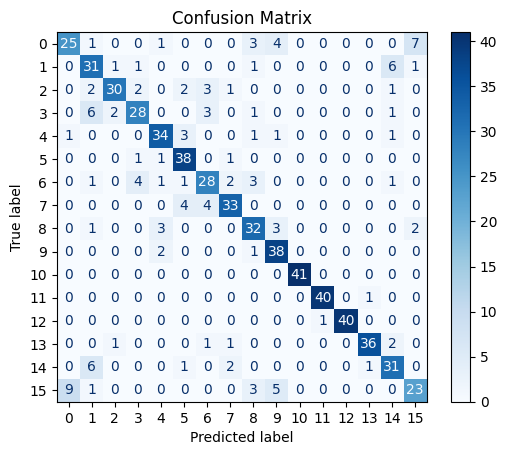

In [70]:
print_confusion_matrix()